---
# COVID-19 exponential growth data fitting
---

### Scientific questions:
- What is exponential growth?
- Why does the growth rate of COVID-19 positive cases follow the exponential growth?
- What does this imply?

Find this YouTube video for a good introduction:
https://www.youtube.com/watch?v=Kas0tIxDvrg

### We assume:
- Tests are enough (all positive cases are tested).
- Tests are accurate (no false positive/negative cases).
- Limitations due to lack of resources or due to human error are ignored (a big assumption!)

**Later we will see, although these fators are not considered in the model development, by tuning the parameter $r$ to fit the real data, we actually take these factors into account.**

Now, let's think about a simple COVID-19 exponential growth model:

Let's define
- $N$ = Number of total cases
- $E$ = Average number of people exposed to an infected person each day
- $p$ = Probability of each exposure becoming an infection

So, the change in the total cases for one day is

$$ \frac{\Delta N}{\Delta t} = E \cdot p \cdot N $$

If the timestep $\Delta t$ is infinitesimal, the equation becomes

$$ \frac{d N}{d t} = E \cdot p \cdot N $$

For simplicity, let 
$$ r = E \cdot p $$

We then have our simplest population growth model

$$ \frac{d N}{d t} = rN $$

**Assuming parameter $r$ is a constant**, we solve for the equation

$$ N(t) = N_0 e^{rt} $$

where $N_0$ is the total case number at $t = 0$.

Now we have a model for COVID-19 cases (ideally), which means we can use the model to predict the number of cases at any time, **given the initial condition $N_0$ and parameter $r$**.

Let's try an experiment: $N_0 = 1$, $r = 0.2$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

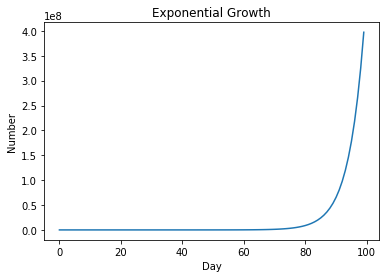

In [2]:
N0 = 1
r = 0.2
t = np.arange(100)
N = N0 * np.exp(r*t)
plt.plot(t, N)
plt.xlabel('Day')
plt.ylabel('Number')
plt.title('Exponential Growth')
plt.show()

What if we use a log-scale y axis instead?

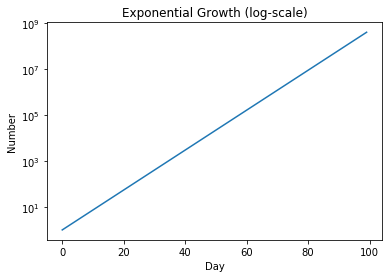

In [3]:
plt.plot(t, N)
plt.yscale('log')
plt.xlabel('Day')
plt.ylabel('Number')
plt.title('Exponential Growth (log-scale)')
plt.show()

Yes, a straight line. Why?

If we calculate the natural logarithm of both sides of our exponential growth model, we get

$$ ln \frac{N(t)}{N_0} = rt $$

Define

$$ y = ln \frac{N(t)}{N_0} $$

Finally we have

$$ y = rt $$

Since we have assumed that parameter $r$ is a constant, the above equation indicates a **linear relationship** between $y$ and $t$. We can use **linear regression** method to fit our model to the real COVID-19 data!

In [4]:
import pandas as pd
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

df = pd.read_csv(url)
#df.shape

datacol=[] # list for collecting all column indices: only columns with data
datelist=[] # list with the date strings
j=0
for c in df.columns:
    if c == "Country/Region":
        col_country=j
    if "/20" in c:
        datacol.append(j)
        datelist.append(c)
    j=j+1

Here we choose the total positive cases in the US.

In [5]:
country = "US"

rowlist=[]
k=0
while k<df.shape[0]: # for all rows
    if df.iloc[k,col_country] == country:
        rowlist.append(k)
        #print ("Found the row for " + country + ":", k)
        #print (df.iloc[k,datacol])
        x=df.iloc[k,datacol]
    k=k+1
    
x=np.array(x,dtype=int)   # cumulative confirmed cases 

# dealing with dates for nicer time axis labeling in the plots
# help and examples can be found here
# https://www.journaldev.com/23365/python-string-to-datetime-strptime
import datetime as dt
time=[]
for datestring in datelist:
    t=dt.datetime.strptime(datestring, '%m/%d/%y')
    time.append(t)
    #print(t)
time=np.array(time)

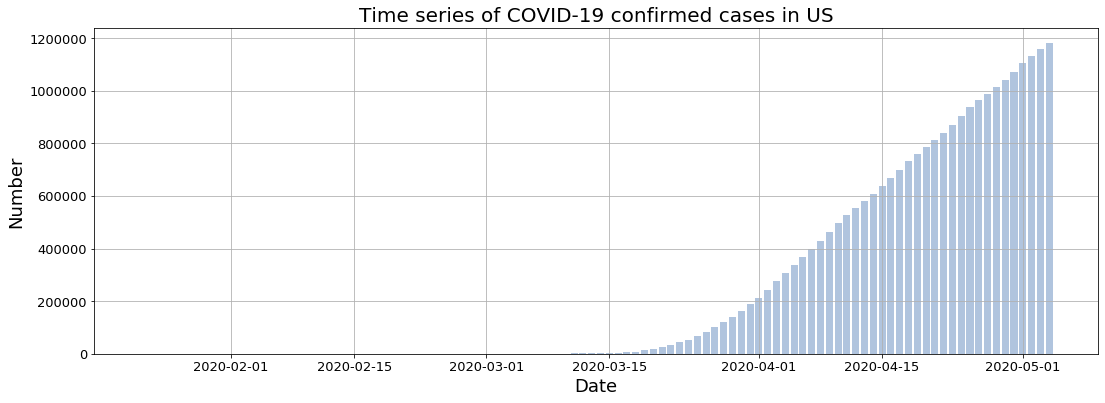

In [6]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
plt.figure(figsize=(18,6))
plt.bar(time, x, color='lightsteelblue')
plt.xlabel("Date", fontsize=18)
plt.ylabel("Number", fontsize=18)
plt.title("Time series of COVID-19 confirmed cases in " + country, fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.grid()

### Let's do data fitting using linear regression method!

First, calculate $N$ from our exponential growth model (with a constant $r$):

In [7]:
# Exponential growth model
from scipy import stats
N0 = x[0]   # total cases at Day 1 from real COVID-19 data
t = np.arange(len(time))
y = np.log(x/N0)

linear_reg = stats.linregress(t, y)
r = linear_reg[0]  # slope
N = N0*np.exp(r*t)

Then, compare our results with the real COVID-19 data:

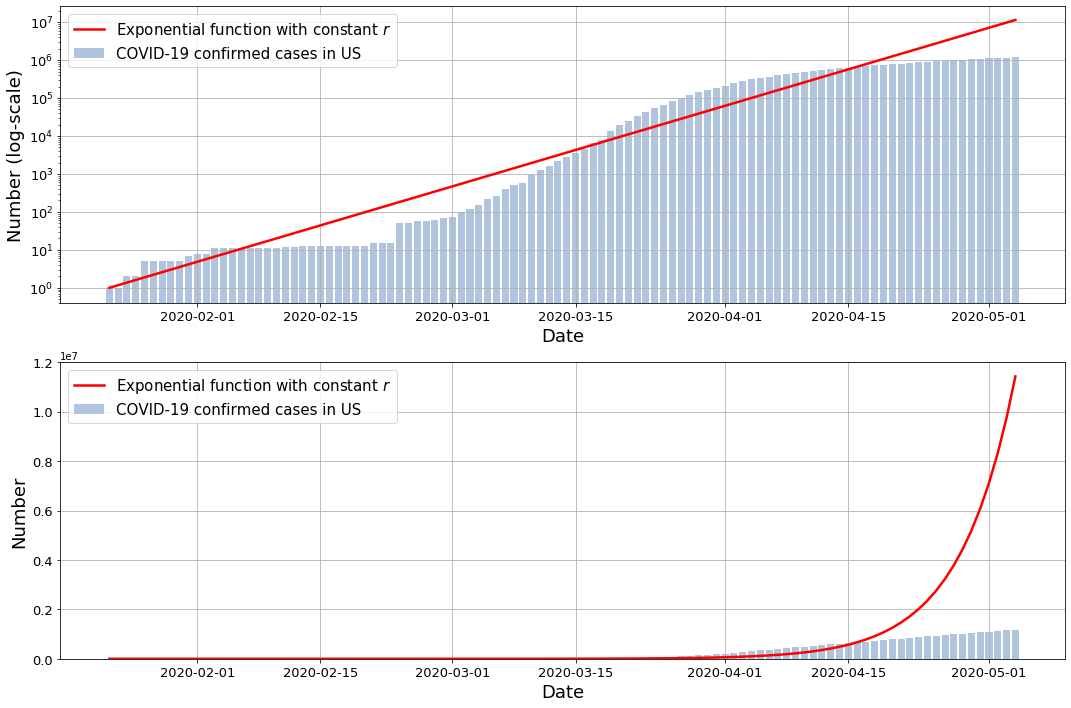

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(18,12))

axes[0].set_yscale('log')
axes[0].set_ylabel("Number (log-scale)", fontsize=18)
axes[1].set_ylabel("Number", fontsize=18)
for ax in axes:
    ax.bar(time, x, color='lightsteelblue', label='COVID-19 confirmed cases in ' + country)
    ax.plot(time, N, color='r', linewidth=2.5, label='Exponential function with constant $r$')
    ax.set_xlabel("Date", fontsize=18)
    ax.legend(fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.grid()

### This is obviously unrealistic. What's wrong with our model?

An important reason is that **$r$ cannot be a constant**. In reality, $r$ changes dramatically with time, which makes sense, because actions like social distancing, washing hands frequently and wearing masks have slowed down the growth rate and flattened the curve.

Strictly speaking, $r$ changes at each timestep. To simplify our problem, we can 
- Discretize our model and divide it into several different periods,
- In each period, assume the $r$ is a constant.

In [9]:
def find_index(year,month,date):
    '''Find the index for a given date'''
    for i,d in enumerate(time):
        if d == dt.datetime(year, month, date, 0, 0):
            return i

In [10]:
def find_r(start, end):
    '''Calculate r for a given period'''
    t = np.arange(end-start+1)
    y = np.log(x[start:end+1]/N0)
    linear_reg = stats.linregress(t, y)
    return linear_reg[0], t

In [11]:
r=[]
r1,t1 = find_r(0,find_index(2020,2,1))
N1 = N0*np.exp(r1*t1)
r.append(r1)

r2,t2 = find_r(find_index(2020,2,1), find_index(2020,2,23))
N2 = N1[-1]*np.exp(r2*t2)
r.append(r2)

r3,t3 = find_r(find_index(2020,2,23), find_index(2020,4,1))
N3 = N2[-1]*np.exp(r3*t3)
r.append(r3)

r4,t4 = find_r(find_index(2020,4,1), find_index(2020,4,20))
N4 = N3[-1]*np.exp(r4*t4)
r.append(r4)

r5,t5 = find_r(find_index(2020,4,20), find_index(2020,5,4))
N5 = N4[-1]*np.exp(r5*t5)
r.append(r5)
r

[0.20693001785446552,
 0.021659201456016568,
 0.25939894321410617,
 0.06538743954306761,
 0.02925643527459069]

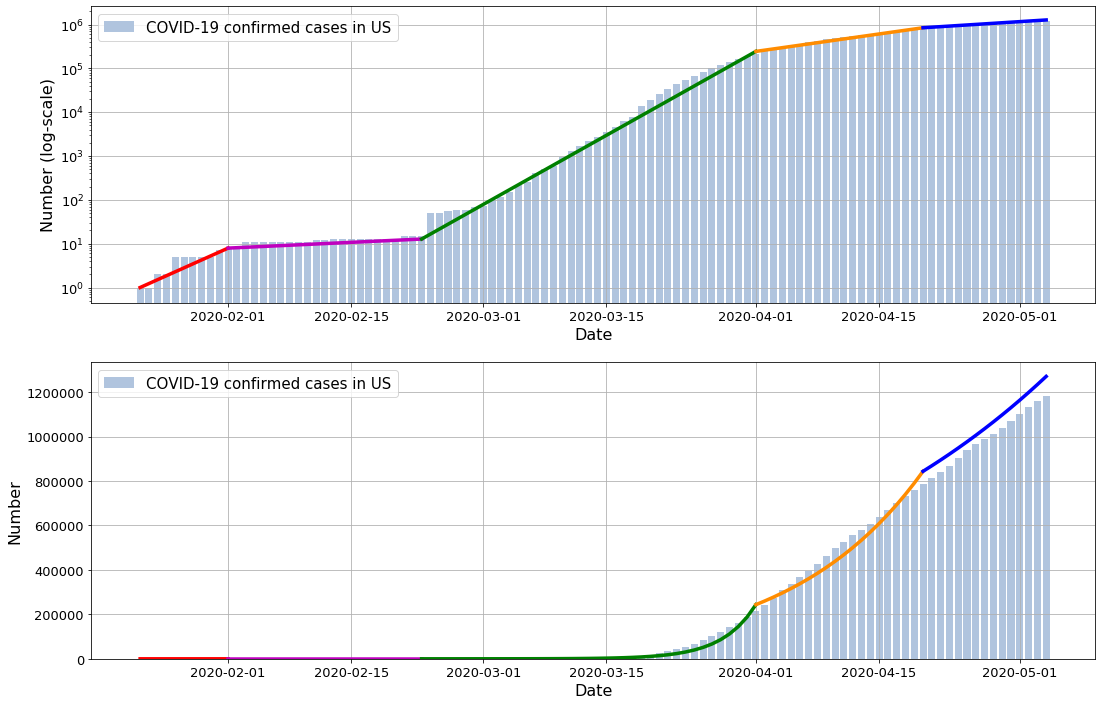

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(18,12))

axes[0].set_yscale('log')
axes[0].set_ylabel('Number (log-scale)', fontsize=16)
axes[1].set_ylabel('Number', fontsize=16)
for ax in axes:
    ax.bar(time, x, color='lightsteelblue', label='COVID-19 confirmed cases in ' + country)
    ax.plot(time[0                    :find_index(2020,2,1)+1],  N1, linewidth=3.5, color='r')
    ax.plot(time[find_index(2020,2,1) :find_index(2020,2,23)+1], N2, linewidth=3.5, color='m')
    ax.plot(time[find_index(2020,2,23):find_index(2020,4,1)+1],  N3, linewidth=3.5, color='g')
    ax.plot(time[find_index(2020,4,1) :find_index(2020,4,20)+1], N4, linewidth=3.5, color='darkorange')
    ax.plot(time[find_index(2020,4,20):find_index(2020,5,4)+1],  N5, linewidth=3.5, color='b')
    ax.set_xlabel('Date', fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.legend(fontsize=15)
    ax.grid()